In [ ]:
!pip install transformers datasets torch scikit-learn matplotlib seaborn -q

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from datasets import load_dataset
from collections import Counter


np.random.seed(42)
torch.manual_seed(42)

**Dataset**:

Use the IMDB Movie Reviews dataset for sentiment analysis (classifying reviews as positive or negative)

In [ ]:
# IMDB dataset
dataset = load_dataset('imdb')

# Use subset for faster training
train_size = 1000
test_size = 500

train_data = dataset['train'].shuffle(seed=42).select(range(train_size))
test_data = dataset['test'].shuffle(seed=42).select(range(test_size))

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"\nSample review: {train_data[0]['text'][:200]}...")
print(f"Label: {train_data[0]['label']} (0=negative, 1=positive)")

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Training samples: 1000
Test samples: 500

Sample review: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. F...
Label: 1 (0=negative, 1=positive)


Fine-tune the pre-trained BERT model

- Use a pre-trained BERT model from Hugging Face’s Transformers library.
- Steps:
  - Load the BERT-base model and replace the final classification layer with a dense layer that matches the number of classes in
your dataset.
  - Fine-tune the model using a suitable optimizer (e.g., AdamW) and a learning rate scheduler.
  - Train the model on your dataset for a fixed number of epochs (e.g., 3-5 epochs).

Evaluation:
  -  Evaluate the model using metrics such as accuracy, precision, recall, and F1 score.
  - Visualize the training process by plotting loss and accuracy over the epochs.

In [ ]:
# Pre-trained Finetuning of BERT Model

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# Tokenize the data
def tokenize_data(data, max_length=128):
    texts = [item['text'] for item in data]
    labels = [item['label'] for item in data]

    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )

    return encodings, torch.tensor(labels)

train_encodings, train_labels = tokenize_data(train_data)
test_encodings, test_labels = tokenize_data(test_data)

# DataLoader
class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDBDataset(train_encodings, train_labels)
test_dataset = IMDBDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Setup optimizer and scheduler
epochs = 3
optimizer = AdamW(bert_model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Training function for BERT
def train_bert_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss = 0
    predictions, true_labels = [], []

    for batch in loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(true_labels, predictions)

    return avg_loss, accuracy

# Evaluation function
def evaluate_model(model, loader, is_bert=True):
    """Evaluate model on test set"""
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in loader:
            if is_bert:
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                labels = batch['labels']

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
            else:
                inputs, labels = batch
                logits = model(inputs)

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='binary'
    )

    return accuracy, precision, recall, f1, predictions, true_labels


# Train BERT

bert_start_time = time.time()
bert_train_losses, bert_train_accs = [], []

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train_bert_epoch(
        bert_model, train_loader, optimizer, scheduler
    )
    bert_train_losses.append(train_loss)
    bert_train_accs.append(train_acc)
    print(f"  Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

bert_training_time = time.time() - bert_start_time
print(f"\nBERT Training Time: {bert_training_time:.2f} seconds")

# Evaluate BERT
print("\nEvaluating BERT model...")
bert_acc, bert_prec, bert_rec, bert_f1, bert_preds, bert_true = evaluate_model(
    bert_model, test_loader, is_bert=True
)

print(f"\nResults:")
print(f"  Accuracy:  {bert_acc}")
print(f"  Precision: {bert_prec}")
print(f"  Recall:    {bert_rec}")
print(f"  F1 Score:  {bert_f1}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
  Training Loss: 0.6739, Accuracy: 0.5770

Epoch 2/3
  Training Loss: 0.4367, Accuracy: 0.8100

Epoch 3/3
  Training Loss: 0.3094, Accuracy: 0.8810

BERT Training Time: 3613.12 seconds

Evaluating BERT model...

Results:
  Accuracy:  0.842
  Precision: 0.8058608058608059
  Recall:    0.8943089430894309
  F1 Score:  0.8477842003853564


Train a model
-  Build and train a simpler **LSTM** or RNN model for text classification from scratch.
- Train the model on the same dataset using the same number of epochs.

Evaluation:
  - Evaluate the model using the same metrics: accuracy, precision, recall, and F1 score.
  - Compare training and validation loss and accuracy

In [ ]:
# Training LSTM MODEL

# Build vocabulary from training data
def build_vocab(data, vocab_size=10000):
    word_counts = Counter()
    for item in data:
        words = item['text'].lower().split()
        word_counts.update(words)

    vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_counts.most_common(vocab_size))}
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1

    return vocab

vocab = build_vocab(train_data)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

# Encode text to sequence of integers
def encode_text(text, vocab, max_length=64):
    words = text.lower().split()
    encoded = [vocab.get(word, vocab['<UNK>']) for word in words]

    if len(encoded) < max_length:
        encoded += [vocab['<PAD>']] * (max_length - len(encoded))
    else:
        encoded = encoded[:max_length]

    return encoded

train_sequences = torch.tensor([encode_text(item['text'], vocab) for item in train_data])
test_sequences = torch.tensor([encode_text(item['text'], vocab) for item in test_data])
train_labels_lstm = torch.tensor([item['label'] for item in train_data])
test_labels_lstm = torch.tensor([item['label'] for item in test_data])

# Create DataLoader for LSTM
lstm_train_dataset = TensorDataset(train_sequences, train_labels_lstm)
lstm_test_dataset = TensorDataset(test_sequences, test_labels_lstm)
lstm_train_loader = DataLoader(lstm_train_dataset, batch_size=32, shuffle=True)
lstm_test_loader = DataLoader(lstm_test_dataset, batch_size=32)

# Define LSTM model
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128, num_layers=2):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=0.3,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden_cat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        dropped = self.dropout(hidden_cat)
        output = self.fc(dropped)
        return output

lstm_model = SentimentLSTM(vocab_size)
criterion = nn.CrossEntropyLoss()
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

print(lstm_model)
# Mode architecture

Vocabulary size: 10002
SentimentLSTM(
  (embedding): Embedding(10002, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
# Training function for LSTM

def train_lstm_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    predictions, true_labels = [], []

    for inputs, labels in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(true_labels, predictions)

    return avg_loss, accuracy

lstm_start_time = time.time()
lstm_train_losses, lstm_train_accs = [], []

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train_lstm_epoch(
        lstm_model, lstm_train_loader, criterion, lstm_optimizer
    )
    lstm_train_losses.append(train_loss)
    lstm_train_accs.append(train_acc)
    print(f"  Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

lstm_training_time = time.time() - lstm_start_time
print(f"\nLSTM Training Time: {lstm_training_time:.2f} seconds")

# Evaluate LSTM
lstm_acc, lstm_prec, lstm_rec, lstm_f1, lstm_preds, lstm_true = evaluate_model(
    lstm_model, lstm_test_loader, is_bert=False
)

print(f"]\nResults:")
print(f"  Accuracy:  {lstm_acc:.4f}")
print(f"  Precision: {lstm_prec:.4f}")
print(f"  Recall:    {lstm_rec:.4f}")
print(f"  F1 Score:  {lstm_f1:.4f}")


Epoch 1/3
  Training Loss: 0.6969, Accuracy: 0.4910

Epoch 2/3
  Training Loss: 0.6728, Accuracy: 0.5850

Epoch 3/3
  Training Loss: 0.6228, Accuracy: 0.6610

LSTM Training Time: 20.54 seconds
]
Results:
  Accuracy:  0.5460
  Precision: 0.5272
  Recall:    0.7480
  F1 Score:  0.6185


Performance comparison:
  - Compare the fine-tuned BERT model's performance with the LSTM/RNN model trained from scratch.
  - Analyze which model performs better and under which contexts

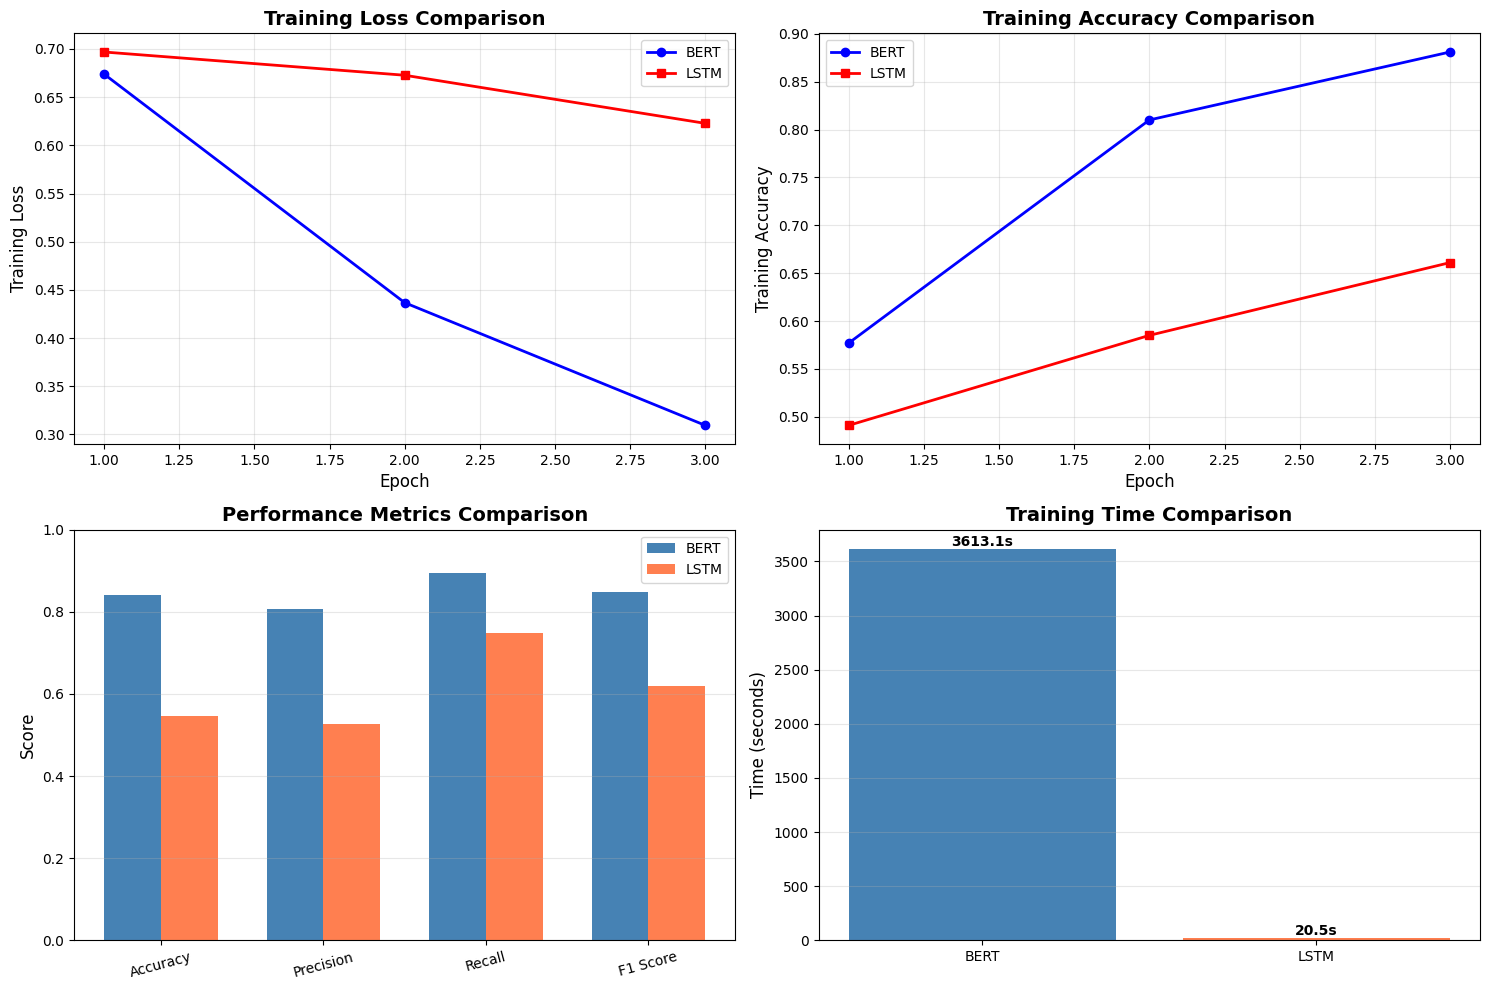

In [ ]:
#  RESULTS: Comparison and Analysis

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training Loss Comparison
axes[0, 0].plot(range(1, epochs + 1), bert_train_losses, 'b-o', label='BERT', linewidth=2)
axes[0, 0].plot(range(1, epochs + 1), lstm_train_losses, 'r-s', label='LSTM', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Training Loss', fontsize=12)
axes[0, 0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Training Accuracy Comparison
axes[0, 1].plot(range(1, epochs + 1), bert_train_accs, 'b-o', label='BERT', linewidth=2)
axes[0, 1].plot(range(1, epochs + 1), lstm_train_accs, 'r-s', label='LSTM', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Training Accuracy', fontsize=12)
axes[0, 1].set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Performance Metrics Comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
bert_metrics = [bert_acc, bert_prec, bert_rec, bert_f1]
lstm_metrics = [lstm_acc, lstm_prec, lstm_rec, lstm_f1]

x = np.arange(len(metrics))
width = 0.35

axes[1, 0].bar(x - width/2, bert_metrics, width, label='BERT', color='steelblue')
axes[1, 0].bar(x + width/2, lstm_metrics, width, label='LSTM', color='coral')
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics, rotation=15)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_ylim([0, 1])

# Training Time Comparison
axes[1, 1].bar(['BERT', 'LSTM'], [bert_training_time, lstm_training_time],
               color=['steelblue', 'coral'])
axes[1, 1].set_ylabel('Time (seconds)', fontsize=12)
axes[1, 1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate([bert_training_time, lstm_training_time]):
    axes[1, 1].text(i, v + 5, f'{v:.1f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Performance Comparison
print(f"{'Metric':<15} {'BERT':<12} {'LSTM':<12} {'Difference':<15}")
print("-" * 80)
print(f"{'Accuracy':<15} {bert_acc:.4f}      {lstm_acc:.4f}      {bert_acc - lstm_acc:+.4f}")
print(f"{'Precision':<15} {bert_prec:.4f}      {lstm_prec:.4f}      {bert_prec - lstm_prec:+.4f}")
print(f"{'Recall':<15} {bert_rec:.4f}      {lstm_rec:.4f}      {bert_rec - lstm_rec:+.4f}")
print(f"{'F1 Score':<15} {bert_f1:.4f}      {lstm_f1:.4f}      {bert_f1 - lstm_f1:+.4f}")
print(f"{'Training Time':<15} {bert_training_time:.1f}s       {lstm_training_time:.1f}s       {bert_training_time - lstm_training_time:+.1f}s")

print("\n2. Performance Analysis:")
print("-" * 80)
performance_diff = bert_acc - lstm_acc
if lstm_training_time > 0:
    time_ratio = bert_training_time / lstm_training_time
else:
    time_ratio = 0

if performance_diff > 0.05:
    print("BERT significantly outperforms LSTM in accuracy")
elif performance_diff > 0:
    print("BERT marginally outperforms LSTM in accuracy")
else:
    print("LSTM performs comparably or better than BERT")

if time_ratio > 0:
    print(f"BERT takes {time_ratio:.1f}x longer to train than LSTM")
print(f"BERT has {sum(p.numel() for p in bert_model.parameters()):,} parameters")
print(f"LSTM has {sum(p.numel() for p in lstm_model.parameters()):,} parameters")


1. Performance Comparison:
--------------------------------------------------------------------------------
Metric          BERT         LSTM         Difference     
--------------------------------------------------------------------------------
Accuracy        0.8420      0.5460      +0.2960
Precision       0.8059      0.5272      +0.2786
Recall          0.8943      0.7480      +0.1463
F1 Score        0.8478      0.6185      +0.2293
Training Time   3613.1s       20.5s       +3592.6s

2. Performance Analysis:
--------------------------------------------------------------------------------
BERT significantly outperforms LSTM in accuracy
BERT takes 175.9x longer to train than LSTM
BERT has 109,483,778 parameters
LSTM has 1,631,498 parameters


ADVANTAGES OF TRANSFER LEARNING (BERT):

*   Higher accuracy with pre-trained knowledge
*   Better understanding of language semantics and context
*   Requires less task-specific training data
*   Captures complex linguistic patterns
*   State-of-the-art performance on NLP tasks

DISADVANTAGES OF TRANSFER LEARNING (BERT):
*   Longer training time (even with fine-tuning)
*   Higher computational requirements (memory & GPU)
*   Larger model size (110M+ parameters)
*   More complex deployment
*   Higher inference latency

ADVANTAGES OF TRAINING FROM SCRATCH (LSTM):
*   Faster training time
*   Smaller model size, easier deployment
*   Lower computational requirements
*   Full control over architecture
*   Faster inference

DISADVANTAGES OF TRAINING FROM SCRATCH (LSTM):
*   Requires more training data for good performance
*   May not capture complex linguistic patterns
*   Lower accuracy on complex tasks
*   No benefit from pre-trained knowledge


USE TRANSFER LEARNING (BERT) WHEN:
*   High accuracy is critical
*   Limited task-specific training data available
*   Complex NLP task requiring deep understanding
*   Computational resources are available
*   Deployment latency is acceptable
*   Working with formal or complex language

USE TRAINING FROM SCRATCH (LSTM) WHEN:
*   Fast training/inference is required
*   Limited computational resources
*   Simple classification task
*   Need lightweight deployment
*   Real-time processing is critical
*   Domain-specific language not in pre-training data



**For production sentiment analysis:**
*   Use BERT for high-stakes applications (financial analysis, medical)
*   Use LSTM for real-time processing (chatbots, streaming data)
*   Consider distilled models (DistilBERT) as a middle ground
*   Use BERT for initial development, then distill to smaller model
*   Evaluate cost-benefit: accuracy gain vs computational cost